In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *

from joblib import Parallel, delayed
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
# from tqdm_joblib import tqdm_joblib

np.set_printoptions(linewidth=120)

In [2]:
import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [2]:
target = np.load('../pretrained_models/Enformer_data/enformer_targets_test_center_2.npy')
print(target.shape)

pred = np.load(f'outputs/Enformer_pred_crop_196608_N.npy')
print(pred.shape)

corr = np.corrcoef(pred.reshape(-1), target.reshape(-1))[0, 1]
print(corr)

FileNotFoundError: [Errno 2] No such file or directory: '../pretrained_models/Enformer_data/enformer_targets_test_center_2.npy'

In [4]:
# for cropped_length in [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 196608]:
#     pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_N.npy')
#     pred_new = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_N_new.npy')
#     print(np.sum((pred-pred_new)>1e-4))

# for cropped_length in [256,512,1024,2048]:
#     pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_zero.npy')
#     pred_new = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_zero_new.npy')
#     print(np.sum((pred-pred_new)>1e-4))


for cropped_length in [8192]:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_N.npy')
    pred_new = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_N_new.npy')
    pred_new_2 = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_N_new_2.npy')
    pred_new_3 = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_N_new_bs_3.npy')
    print(np.sum((pred-pred_new)>1e-4))
    print(np.sum((pred-pred_new_2)>1e-4))
    print(np.sum((pred_new-pred_new_2)>1e-4))

    print(np.sum((pred_new-pred_new_3)>1e-4))
    print(np.sum((pred-pred_new_3)>1e-4))

13
13
0
8716
8722


In [5]:
def compute_metrics_for_each_column_parallel(target, pred, n_jobs=-1):
    num_samples, num_positions, num_tracks = target.shape
    with tqdm_joblib(tqdm(total=num_tracks)) as progress_bar:
        results = Parallel(n_jobs=n_jobs)(
            delayed(pearson)(target[:, :, i].reshape(-1), pred[:, :, i].reshape(-1)) for i in range(num_tracks)
        )
    return np.vstack(results)

In [6]:
# import re
# folder_path = "outputs"

# pattern = re.compile(r"(Enformer_pred_crop_\d+)_repeat_N_new")

# for filename in os.listdir(folder_path):
#     match = pattern.search(filename)
#     if match:
#         base = match.group(1)
#         new_filename = pattern.sub(f"{base}_N_new", filename)
#         old_path = os.path.join(folder_path, filename)
#         new_path = os.path.join(folder_path, new_filename)

#         if os.path.exists(new_path):
#             print(f"文件已存在：{new_filename}，跳过")
#         else:
#             os.rename(old_path, new_path)
#             print(f"重命名：{filename} -> {new_filename}")

In [7]:
length_list = np.array([256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 196608])
positions = np.log2(length_list)

In [11]:
pred_list = []
score_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}.npy')
    # pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_N_new.npy')
    # pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_zero.npy')
    # pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_random.npy')
    # pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_genome.npy')
    # pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_repeat.npy')
    pred_list.append(pred)
    score = compute_metrics_for_each_column_parallel(target, pred)
    score_list.append(score)
pred_list = np.stack(pred_list)
score_list = np.stack(score_list)

np.save('Enformer_score_no', score_list)
# np.save('Enformer_score_N_new', score_list)
# np.save('Enformer_score_zero.npy', score_list)
# np.save('Enformer_score_random.npy', score_list)
# np.save('Enformer_score_genome.npy', score_list)
# np.save('Enformer_score_repeat.npy', score_list)

  0%|          | 0/5313 [00:00<?, ?it/s]

100%|██████████| 5313/5313 [00:00<00:00, 10077.19it/s]


In [8]:
score_list = []

for cropped_length in length_list:
    pred_list = []
    for seed in range(5):
        pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_random_{seed}.npy')
        # pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_genome_{seed}.npy')
        pred_list.append(pred)
    pred_list = np.stack(pred_list)
    pred = np.mean(pred_list, axis=0)
    score = compute_metrics_for_each_column_parallel(target, pred)
    score_list.append(score)

score_list = np.stack(score_list)
print(score_list.shape)

np.save('Enformer_score_random_mean.npy', score_list)
# np.save('Enformer_score_genome_mean.npy', score_list)

100%|██████████| 5313/5313 [00:00<00:00, 10027.03it/s]

(11, 5313, 2)


In [9]:
pred_list = []
score_list = []

for cropped_length in length_list:
    for seed in range(5):
        pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_random_{seed}.npy')
        # pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_genome_{seed}.npy')
        score = compute_metrics_for_each_column_parallel(target, pred)
        pred_list.append(pred)
        score_list.append(score)

pred_list = np.stack(pred_list)
score_list = np.stack(score_list)
print(pred_list.shape)
print(score_list.shape)


score_list = score_list.reshape(11, 5, 5313, 2)

np.save('Enformer_score_random_5_times.npy', score_list)
# np.save('Enformer_score_genome_5_times.npy', score_list)

  0%|          | 0/5313 [00:00<?, ?it/s]

100%|██████████| 5313/5313 [00:00<00:00, 9598.19it/s] 


(55, 1937, 2, 5313)
(55, 5313, 2)


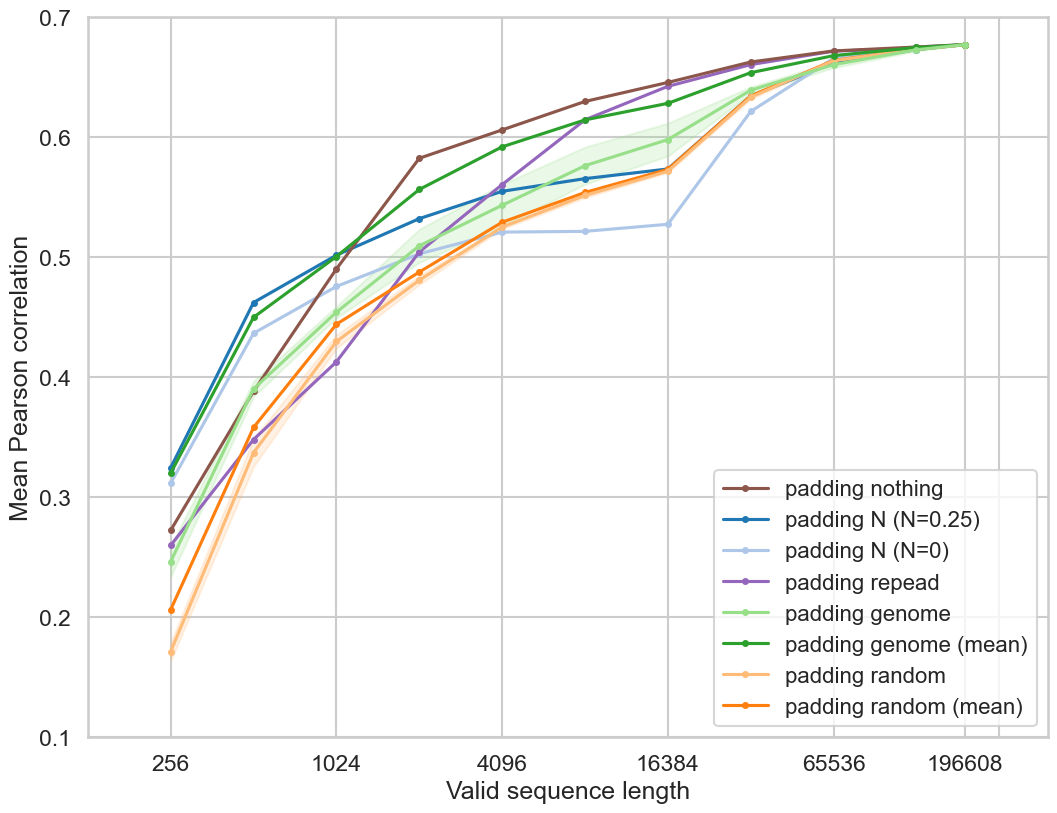

In [15]:
plt.figure(figsize=(12, 9), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)

score_list = np.load('Enformer_score_N.npy')
data = np.nanmean(score_list[:, :, 0], axis=1)
plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding N (N=0.25)',
    color=tab20_colors[0],
)

score_list = np.load('Enformer_score_zero.npy')
data = np.nanmean(score_list[:, :, 0], axis=1)
plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding N (N=0)',
    color=tab20_colors[1],
)

score_list = np.load('Enformer_score_repeat.npy')
data = np.nanmean(score_list[:, :, 0], axis=1)
plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding repead',
    color=tab20_colors[8],
)

score_list = np.load('Enformer_score_no.npy')
data = np.nanmean(score_list[:, :, 0], axis=1)
plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding nothing',
    color=tab20_colors[10],
)

score_list = np.load('Enformer_score_random_mean.npy')
data = np.nanmean(score_list[:, :, 0], axis=1)
plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding random (mean)',
    color=tab20_colors[2],
)

score_list = np.load('Enformer_score_random_5_times.npy')
replicate_mean = np.nanmean(score_list[:, :, :, 0], axis=2)
# 对 5 次重复在 axis=0 做平均和标准差
data = np.mean(replicate_mean, axis=1)     # shape (11,)
data_std = np.std(replicate_mean, axis=1)  # shape (11,)
# plt.errorbar(positions, data, yerr=data_std, marker="o", markersize=4, label='padding genome', color=tab20_colors[5],)

plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding random',
    color=tab20_colors[3],
)
# 在「mean ± std」区域之间填充半透明色
plt.fill_between(
    positions,
    data - data_std,
    data + data_std,
    color=tab20_colors[3],
    alpha=0.2,
)

score_list = np.load('Enformer_score_genome_mean.npy')
data = np.nanmean(score_list[:, :, 0], axis=1)
plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding genome (mean)',
    color=tab20_colors[4],
)

score_list = np.load('Enformer_score_genome_5_times.npy')
replicate_mean = np.nanmean(score_list[:, :, :, 0], axis=2)
data = np.mean(replicate_mean, axis=1)     # shape (11,)
data_std = np.std(replicate_mean, axis=1)  # shape (11,)

plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding genome',
    color=tab20_colors[5],
)
plt.fill_between(
    positions,
    data - data_std,
    data + data_std,
    color=tab20_colors[5],
    alpha=0.2,
)

handles, labels = plt.gca().get_legend_handles_labels()
desired_order = [
    'padding nothing',
    'padding N (N=0.25)',
    'padding N (N=0)',
    'padding repead',
    'padding genome',
    'padding genome (mean)',
    'padding random',
    'padding random (mean)',
]
# 1. labels 与 handles 对应
label_to_handle = dict(zip(labels, handles))
# 2. 按 desired_order 重排
reordered_handles = [label_to_handle[label] for label in desired_order]
reordered_labels = desired_order

plt.legend(reordered_handles, reordered_labels, fontsize=16, loc='lower right')

x_ticks = [8, 10, 12, 14, 16, 16 + np.log2(3), 18]
x_labels = [256, 1024, 4096, 16384, 65536, 196608, '']
plt.xlim(np.min(positions) - 1, np.max(positions) + 1)
plt.ylim(0.1, 0.7)
plt.xticks(x_ticks, x_labels)
plt.yticks(np.arange(0.1, 0.71, 0.1))
plt.xlabel('Valid sequence length')
plt.ylabel('Mean Pearson correlation')

plt.savefig('figures/Enformer_padding_Pearson.png', dpi=400)
plt.show()


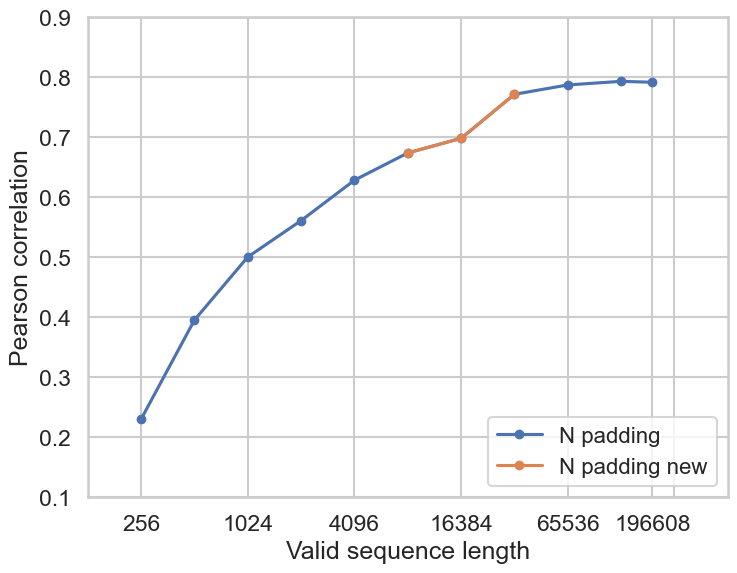

In [14]:
# # enformer

# plt.figure(figsize=(8, 6), dpi=100)
# plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)


# # pred_list = []
# # for cropped_length in length_list:
# #     pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}.npy')
# #     pred_list.append(pred)
# # pred_list = np.stack(pred_list)
# # corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# # corr = corr[-1, :-1]
# # plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='w/o padding')


# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_N.npy')
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='N padding')





# pred_list = []
# for cropped_length in [8192, 16384, 32768]:
#     pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_N_new.npy')
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# plt.plot(np.log2([8192, 16384, 32768]), corr, marker="o", markersize=6, label='N padding new')



# # pred_list = []
# # for cropped_length in length_list:
# #     pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_zero.npy')
# #     pred_list.append(pred)
# # pred_list = np.stack(pred_list)
# # corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# # corr = corr[-1, :-1]
# # plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='zero padding')





# # pred_list = []
# # for cropped_length in length_list:
# #     pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
# #     # print(pred.shape)
# #     pred_list.append(pred)
# # pred_list = np.stack(pred_list)
# # pred_list = pred_list.mean(1)
# # corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# # corr = corr[-1, :-1]
# # plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding')





# plt.xlim(7, 19)
# plt.ylim(0.1, 0.9)
# plt.xticks([8, 10, 12, 14, 16, 16+np.log2(3), 18], labels=[256, 1024, 4096, 16384, 65536, 196608, ''])
# plt.yticks(0.1 * np.arange(1, 10))
# plt.xlabel('Valid sequence length')
# plt.ylabel('Pearson correlation')
# plt.legend(fontsize=16, loc='lower right')
# # plt.savefig('figures/correlation_between_3_padding_methods.png', dpi=400)
# plt.show()

(11, 5, 1937, 2, 5313)
(11, 5, 1937, 2, 5313)


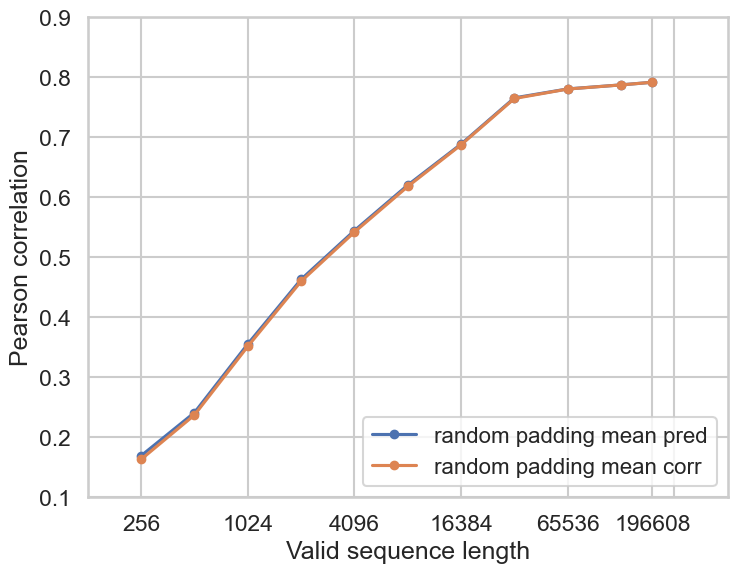

In [4]:
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)




pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
print(pred_list.shape)
pred_list = pred_list.mean(1)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding mean pred')



pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
print(pred_list.shape)
# (11, 5, 1937, 2, 5313)
pred_list = pred_list.reshape(-1, 1937, 2, 5313)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1].reshape(-1, 5).mean(1)
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding mean corr')




plt.xlim(7, 19)
plt.ylim(0.1, 0.9)
plt.xticks([8, 10, 12, 14, 16, 16+np.log2(3), 18], labels=[256, 1024, 4096, 16384, 65536, 196608, ''])
plt.yticks(0.1 * np.arange(1, 10))
plt.xlabel('Valid sequence length')
plt.ylabel('Pearson correlation')
plt.legend(fontsize=16, loc='lower right')
plt.savefig('figures/correlation_random_mean.png', dpi=400)
plt.show()

In [5]:
pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
print(pred_list.shape)
# (11, 5, 1937, 2, 5313)
pred_list = pred_list.reshape(-1, 1937, 2, 5313)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))

print(corr)

(11, 5, 1937, 2, 5313)
[[1.         0.91465899 0.91662061 ... 0.16742964 0.16742964 0.16327258]
 [0.91465899 1.         0.91243314 ... 0.16608902 0.16608902 0.16096631]
 [0.91662061 0.91243314 1.         ... 0.16871918 0.16871918 0.16371049]
 ...
 [0.16742964 0.16608902 0.16871918 ... 1.         1.         0.79138096]
 [0.16742964 0.16608902 0.16871918 ... 1.         1.         0.79138096]
 [0.16327258 0.16096631 0.16371049 ... 0.79138096 0.79138096 1.        ]]
